Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2021/2022
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Logistička regresija

*Verzija: 1.0 
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2021 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **7. studenog 2021. u 23:59h**

------------------------------

### Upute

Ova laboratorijska vježba sastoji se od četiri zadatka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [2]:
# Učitaj osnovne biblioteke...
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import math
% pylab inline

UsageError: Line magic function `%` not found.


In [3]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h != None:
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX = np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h, XX)))
            else:
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h, XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

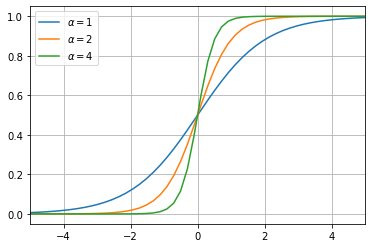

In [24]:
# Vaš kôd ovdje

sigm = lambda x: 1 / (1 + math.exp(-x))

alphas = [1, 2, 4]

limit = 5
x_space = np.linspace(-limit, limit)

plt.figure()
plt.grid()

labels = []

for alpha in alphas:
    plt.plot(x_space, np.vectorize(sigm)(x_space * alpha))
    labels.append('$\\alpha = {}$'.format(alpha))

plt.legend(labels)
plt.xlim(-limit, limit)
plt.show()


**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [77]:
from numpy import linalg
from sklearn.metrics import log_loss
from sklearn.preprocessing import PolynomialFeatures


def lr_h(x, w):
    phi = PolynomialFeatures(1).fit_transform(x.reshape(1, -1))
    return sigm(np.dot(phi, w))


def cross_entropy_error(X, y, w):
    phi = PolynomialFeatures(1).fit_transform(X)
    return log_loss(y, np.vectorize(sigm)(np.dot(phi, w)))


def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    N = np.size(X, 0)
    w = np.zeros(np.size(X, 1) + 1)
    w_history = []

    error_prev = epsilon  # init value

    for i in range(0, max_iter):
        dw0 = 0
        dw = np.zeros(np.size(X, 1))

        for j in range(0, N):
            h = lr_h(X[j], w)
            dw0 -= (h - y[j])
            dw -= (h - y[j]) * X[j]

        w[0] += dw0 * eta
        w[1:] = w[1:] * (1 - eta * alpha) + eta * dw

        if trace:
            w_history.append(w.copy())

        error_curr = cross_entropy_error(X, y, w)

        if abs(error_curr - error_prev) < epsilon:
            print('Minimum reached on iter {}/{}.'.format(i, max_iter))
            break

        error_prev = error_curr

    if trace:
        return w, w_history

    else:
        return w


### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

Minimum reached on iter 3811/10000.
Pogreška: 0.04616210323489932
Težine: [ 8.36424316 -2.52257277  0.43302947]


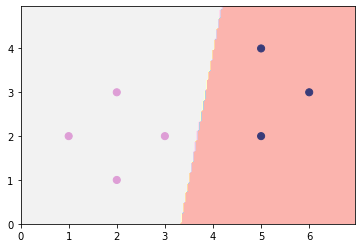

In [78]:
seven_X = np.array([[2, 1], [2, 3], [1, 2], [3, 2], [5, 2], [5, 4], [6, 3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

weights = lr_train(seven_X, seven_y, epsilon=0.00001, max_iter=10000)
print('Pogreška: {}'.format(cross_entropy_error(seven_X, seven_y, weights)))
print('Težine: {}'.format(weights))

h = lambda x: lr_h(x, weights) >= 0.5

plot_2d_clf_problem(seven_X, seven_y, h)


**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

In [79]:
from sklearn.metrics import zero_one_loss


def predict(X, w):
    phi = PolynomialFeatures(1).fit_transform(X)
    predictions = np.vectorize(sigm)(np.dot(phi, w))
    return np.vectorize(lambda x: 1 if x >= 0.5 else 0)(predictions)

Minimum reached on iter 1141/2000.
Minimum reached on iter 946/2000.
Minimum reached on iter 510/2000.
Minimum reached on iter 377/2000.


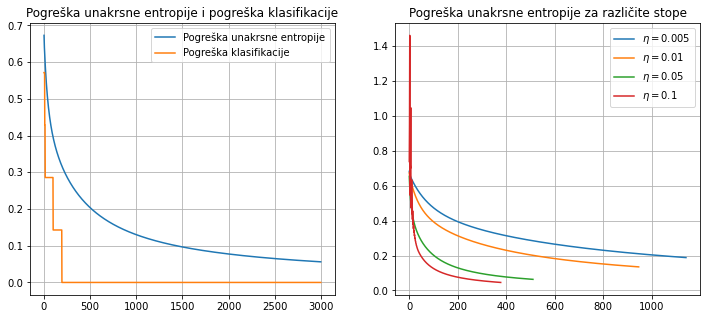

In [88]:
# Vaš kôd ovdje

stope = [0.005, 0.01, 0.05, 0.1]

plt.figure(figsize=(12, 5))

weights_d, weights_history_d = lr_train(seven_X, seven_y, trace=True, epsilon=0.00001, max_iter=3000)
error_unakrs = []
error_klas = []

for weight_current in weights_history_d:
    error_unakrs.append(cross_entropy_error(seven_X, seven_y, weight_current))
    error_klas.append(zero_one_loss(seven_y, predict(seven_X, weight_current)))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(error_unakrs)
plt.plot(error_klas)
plt.title('Pogreška unakrsne entropije i pogreška klasifikacije')
plt.legend(['Pogreška unakrsne entropije', 'Pogreška klasifikacije'])

plt.subplot(1, 2, 2)
plt.grid()
plt.title('Pogreška unakrsne entropije za različite stope')
for stopa in stope:
    error_unakrs_stope = []
    weights_d_stope, weights_history_d_stope = lr_train(seven_X, seven_y, eta=stopa, trace=True)

    for weight_current in weights_history_d_stope:
        error_unakrs_stope.append(cross_entropy_error(seven_X, seven_y, weight_current))

    plt.plot(error_unakrs_stope, label='$\eta = {}$'.format(stopa))
plt.legend()
plt.show()







**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

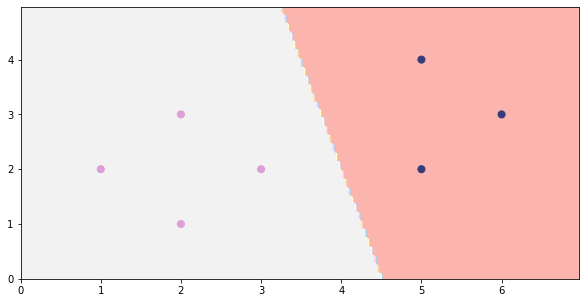

In [92]:
from sklearn.linear_model import LogisticRegression

# Vaš kôd ovdje

lin_reg = LogisticRegression(max_iter=2000, tol=0.0001).fit(seven_X, seven_y)

plt.figure(figsize=(10, 5))
plot_2d_clf_problem(seven_X, seven_y, lambda x: lin_reg.predict(x))

### 2. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [93]:
outlier_X = np.append(seven_X, [[12, 8]], axis=0)
outlier_y = np.append(seven_y, 0)

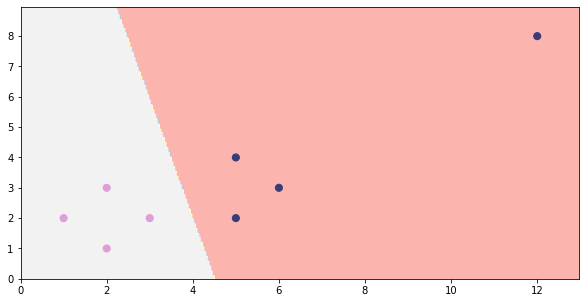

In [95]:
# Vaš kôd ovdje

lin_reg_2 = LogisticRegression(max_iter=2000, tol=0.0001).fit(outlier_X, outlier_y)

plt.figure(figsize=(10, 5))
plot_2d_clf_problem(outlier_X, outlier_y, lambda x: lin_reg_2.predict(x))

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

Minimum reached on iter 946/2000.


[]

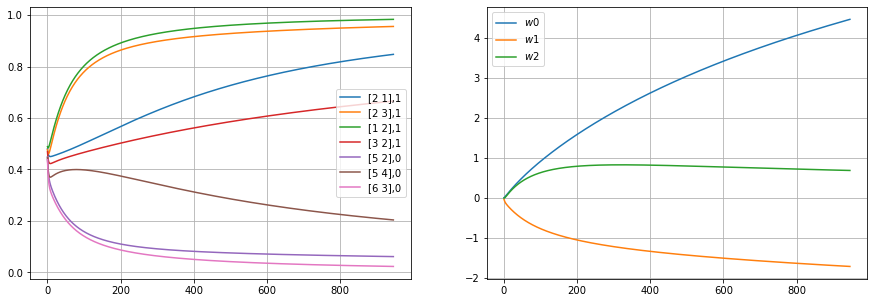

In [105]:
# Vaš kôd ovdje

weights_2_b, weights_2_b_history = lr_train(seven_X, seven_y, trace=True)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for example, value in zip(seven_X, seven_y):
    predictions = []
    for weight_current in weights_2_b_history:
        predictions.append(lr_h(example, weight_current))
    plt.plot(predictions, label='{},{}'.format(example, value))
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)

weights_2_b_history = np.array(weights_2_b_history)

for i in range(np.size(weights_2_b_history, 1)):
    plt.plot(weights_2_b_history[:, i], label='$w{}$'.format(i))

plt.grid()
plt.legend()
plt.plot()

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [107]:
unsep_X = np.append(seven_X, [[2, 2]], axis=0)
unsep_y = np.append(seven_y, 0)

Minimum reached on iter 453/2000.


[]

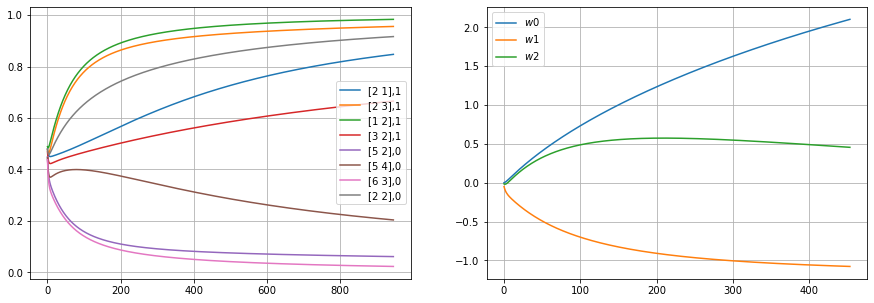

In [108]:
# Vaš kôd ovdje

weights_2_c, weights_2_c_history = lr_train(unsep_X, unsep_y, trace=True)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for example, value in zip(unsep_X, unsep_y):
    predictions = []
    for weight_current in weights_2_b_history:
        predictions.append(lr_h(example, weight_current))
    plt.plot(predictions, label='{},{}'.format(example, value))
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)

weights_2_c_history = np.array(weights_2_c_history)

for i in range(np.size(weights_2_c_history, 1)):
    plt.plot(weights_2_c_history[:, i], label='$w{}$'.format(i))

plt.grid()
plt.legend()
plt.plot()

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 3. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [109]:
from numpy.linalg import norm

Minimum reached on iter 946/2000.
Minimum reached on iter 803/2000.
Minimum reached on iter 404/2000.
Minimum reached on iter 3/2000.


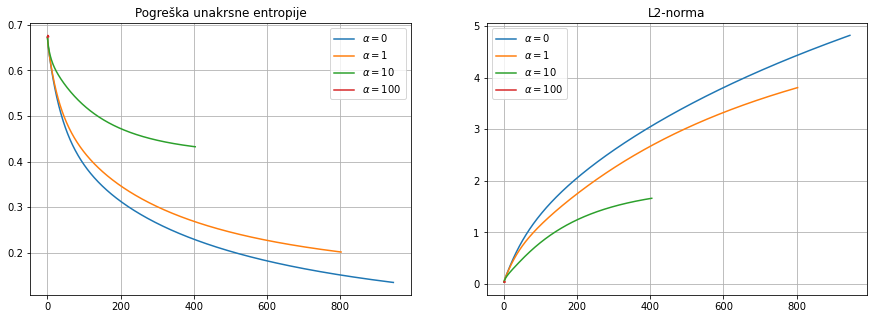

In [111]:
# Vaš kôd ovdje

alphas_3 = [0, 1, 10, 100]

error_unakrs_entr = []
error_l2 = []

for alpha in alphas_3:
    weight_3, weight_3_history = lr_train(seven_X, seven_y, trace=True, alpha=alpha)
    error_unakrs_entr_curr = []
    error_l2_curr = []

    for weight_current in weight_3_history:
        error_unakrs_entr_curr.append(cross_entropy_error(seven_X, seven_y, weight_current))
        error_l2_curr.append(linalg.norm(weight_current))

    error_unakrs_entr.append(error_unakrs_entr_curr)
    error_l2.append(error_l2_curr)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.title('Pogreška unakrsne entropije')
for alpha_err, alpha in zip(error_unakrs_entr, alphas_3):
    plt.plot(alpha_err, label='$\\alpha={}$'.format(alpha))
plt.legend()

plt.subplot(1, 2, 2)
plt.grid()
plt.title('L2-norma')
for alpha_err, alpha in zip(error_l2, alphas_3):
    plt.plot(alpha_err, label='$\\alpha={}$'.format(alpha))
plt.legend()

plt.show()


**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 4. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

In [113]:
from sklearn.preprocessing import PolynomialFeatures

#plot_2d_clf_problem(X, y, lambda x : model.predict(poly.transform(x))

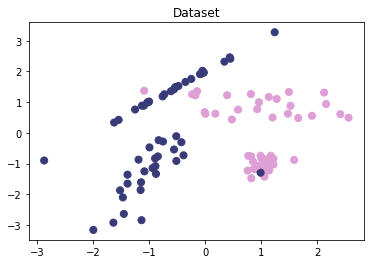

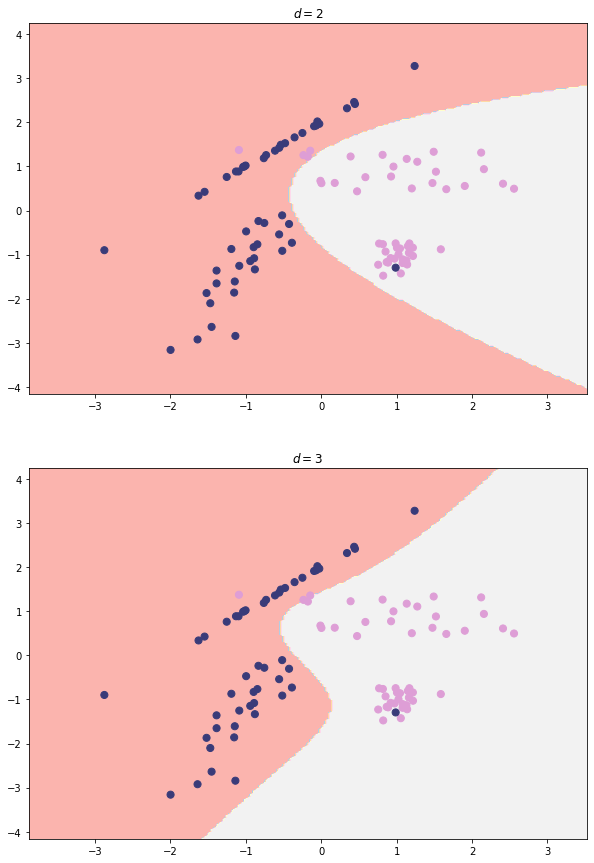

In [136]:
from sklearn.datasets import make_classification

# Vaš kôd ovdje

X, y = make_classification(n_samples=100, n_features=2, n_classes=2, n_clusters_per_class=2, n_redundant=0,
                           random_state=2021)
plot_2d_clf_problem(X, y)
plt.title('Dataset')

d = [2, 3]

plt.figure(figsize=(10, 15))
for degree, i in zip(d, range(np.size(d))):
    plt.subplot(np.size(d), 1, i+1)

    poly = PolynomialFeatures(degree)
    phi = poly.fit_transform(X)

    log_reg_4 = LogisticRegression().fit(phi, y)

    plot_2d_clf_problem(X, y, lambda x: log_reg_4.predict(poly.transform(x)))
    plt.title('$d={}$'.format(degree))


**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?